# Fitting an ODE model to longitudinal data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import string
import pickle
from tqdm import tqdm
from datetime import datetime
#from lmfit import minimize, Parameters
#import multiprocess as mp

# Import my own libraries
# sys.path.append('./utils')
import myUtils as utils
from odeModelClass import ODEModel
from odeModels import create_model
#from fittingUtils import residual, compute_r_sq, load_fit, generate_fitSummaryDf, perform_bootstrap, \
#                            compute_confidenceInterval_prediction, compute_confidenceInterval_parameters

### Cell cycle model

In [2]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,20,1,1], [20,40,1,0], [40,60,1,1], [60,80,1,0], [80,100,1,1], [100,121,1,0]])
myModel.Trim(dt=24.)

In [3]:
data_df_wide = myModel.resultsDf
data_df_wide['Tumor Cell'] = data_df_wide['TumourSize'] - data_df_wide['Dead']

# Add 'alivecell' to the list of variables to plot
variables_to_plot = ['Tumor Cell', 'G1', 'S', 'SD', 'G2', 'G2D', 'Dead']
data_df_long = pd.melt(
    data_df_wide, 
    id_vars=['Time'], 
    value_vars=["Tumor Cell"] + myModel.stateVars, 
    var_name='Variable', 
    value_name='Value'
)

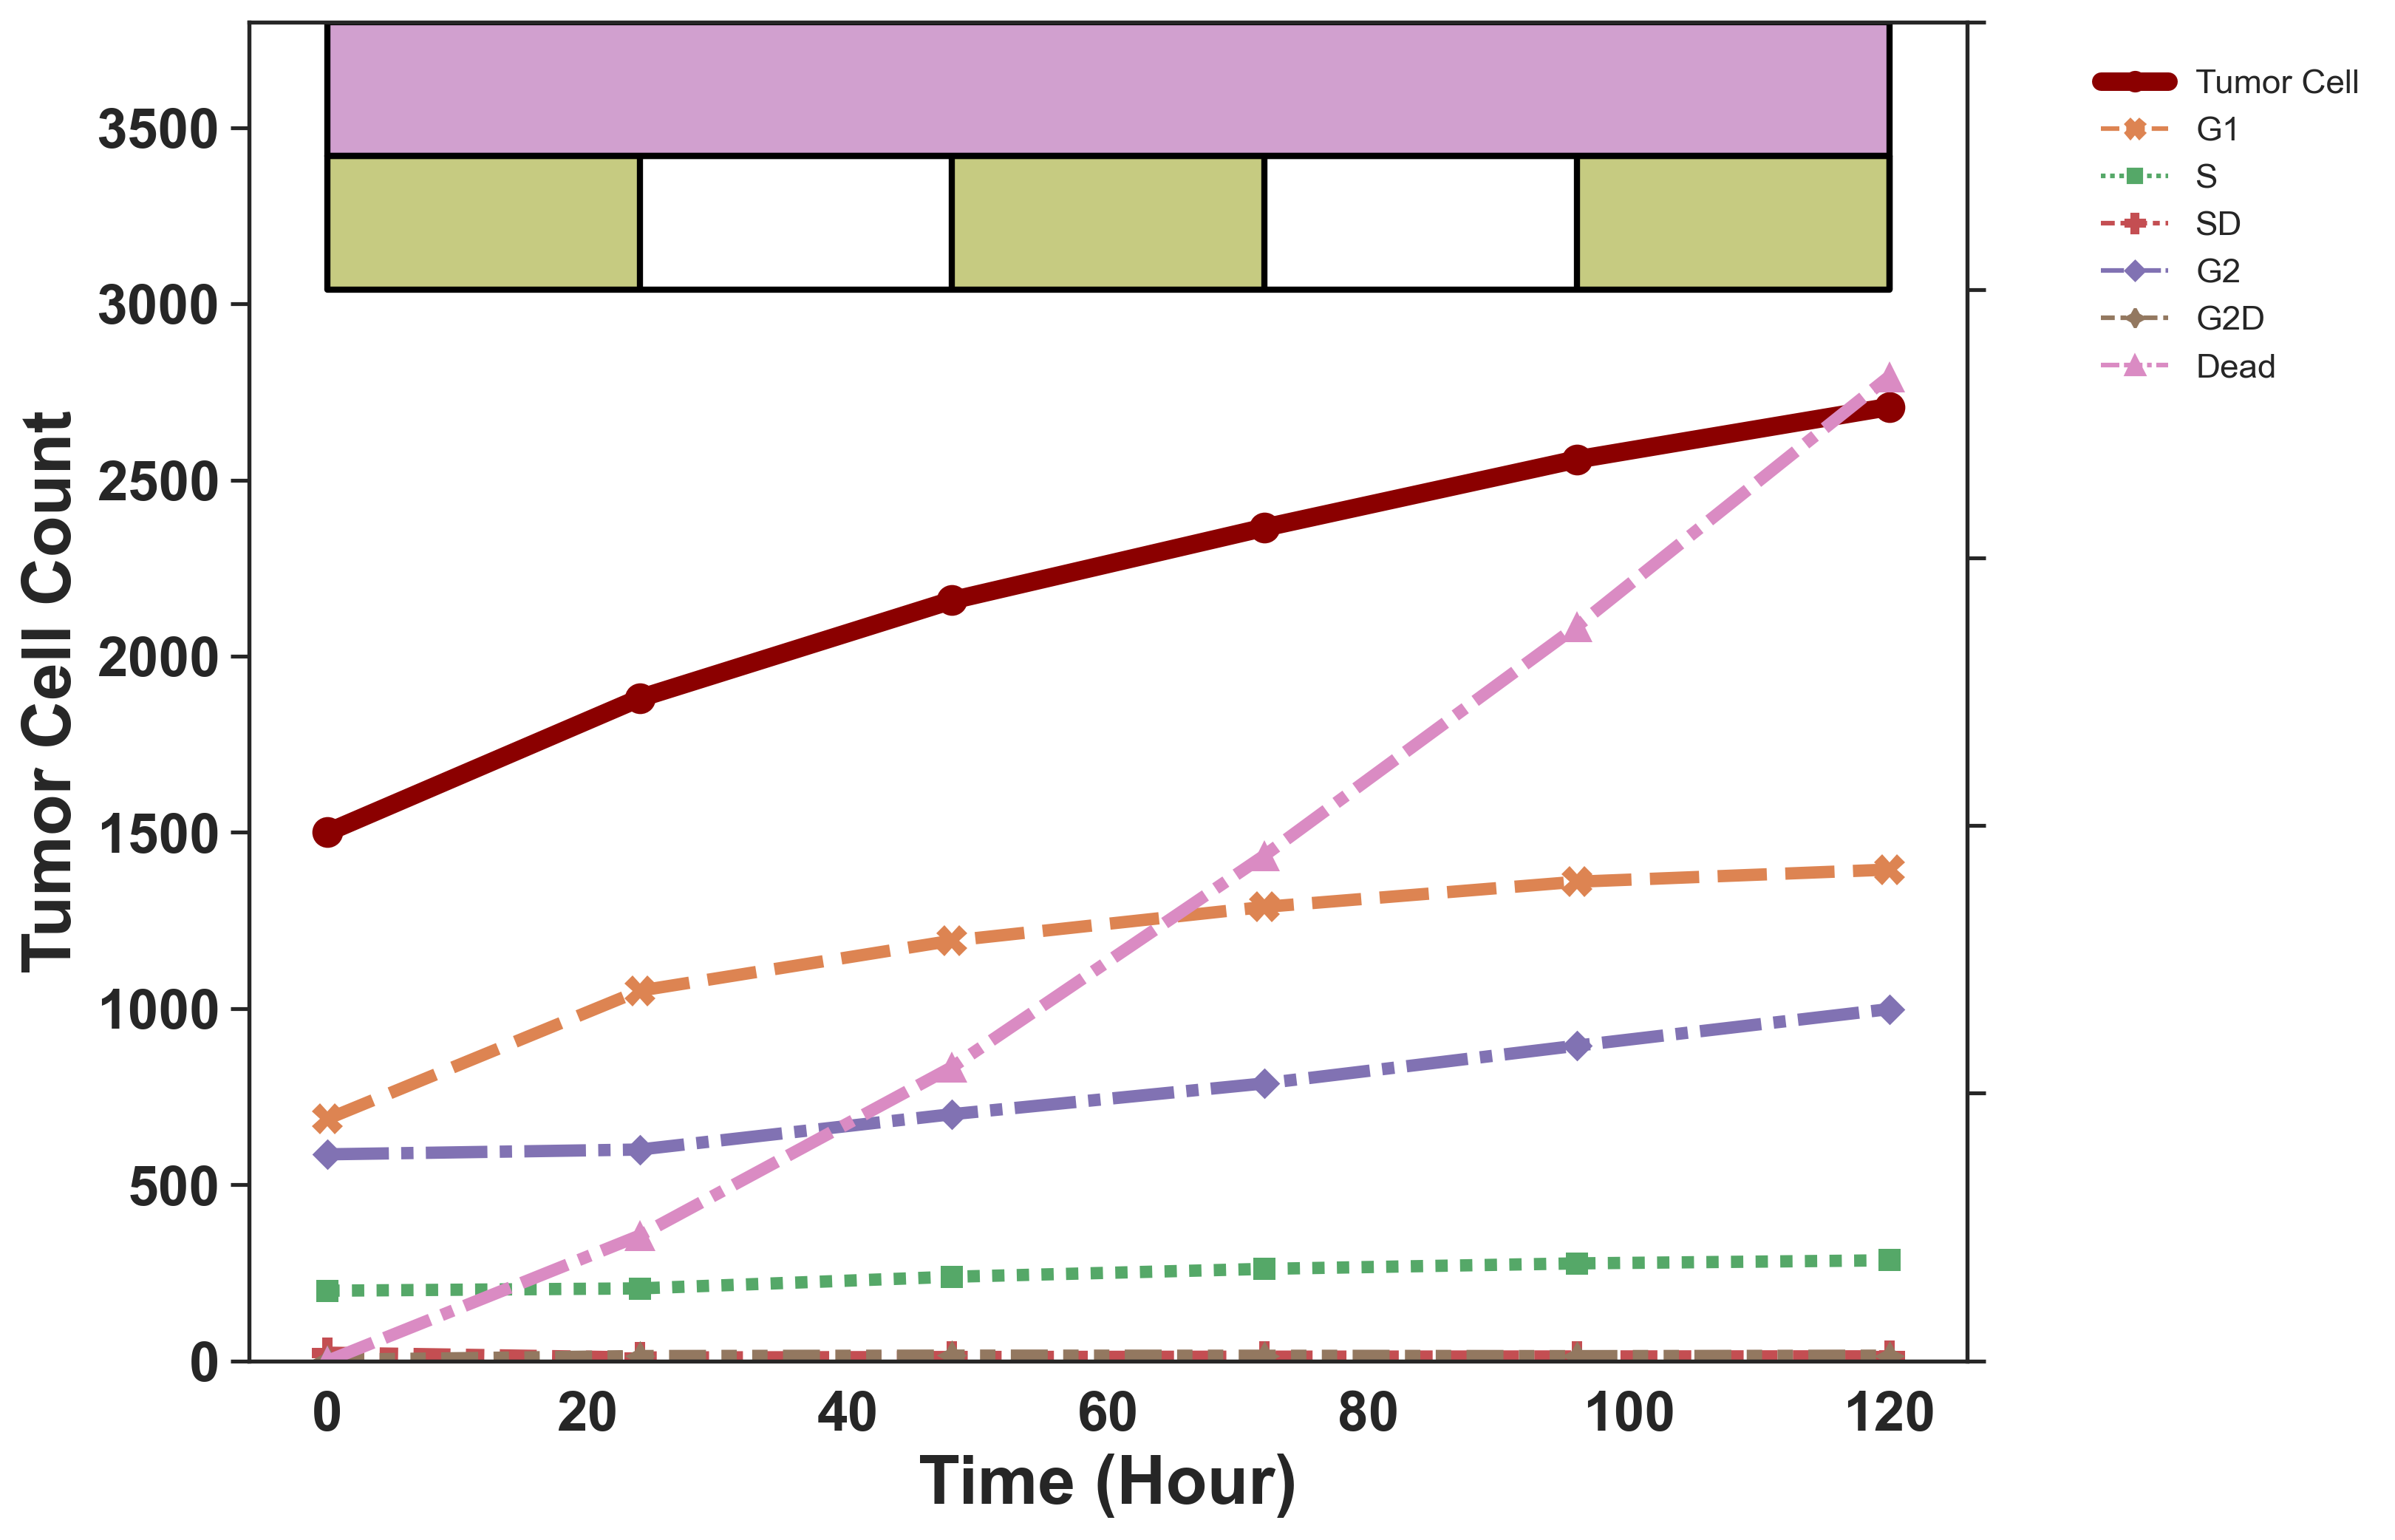

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=4, markersize=10, markeredgewidth=0,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

legend = ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=1, frameon=False)

# Adjust the y-axis limit
ax.set_ylim([0, 3800])

ax.set_xlabel("Time (Hour)", fontsize=22, fontweight="bold")
ax.set_ylabel("Tumor Cell Count", fontsize=22, fontweight="bold")
for tick in ax.get_xticklabels():
    tick.set_fontweight("bold")
for tick in ax.get_yticklabels():
    tick.set_fontweight("bold")
ax.tick_params(axis='both', which='major', labelsize=18)

# Make the "Tumor Cell" line black and thicker in the plot and in the legend
for line, label in zip(ax.get_lines(), variables_to_plot):
    if label == "Tumor Cell":
        line.set_color("#8B0000")
        line.set_linewidth(6)  # Adjust thickness as desired

# Update the legend color for "Tumor Cell" directly
for legend_handle, legend_label in zip(legend.legendHandles, variables_to_plot):
    if legend_label == "Tumor Cell":
        legend_handle.set_color("#8B0000")  # Set color of legend line for "Tumor Cell"
        legend_handle.set_linewidth(6)  # Match the thickness in the legend

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug2_Concentration", "Drug1_Concentration"],
    drug_bar_position=0.8, 
    drugBarColours=sns.xkcd_palette(['baby poop green', 'ugly purple']),
    ax=ax
)

plt.show()


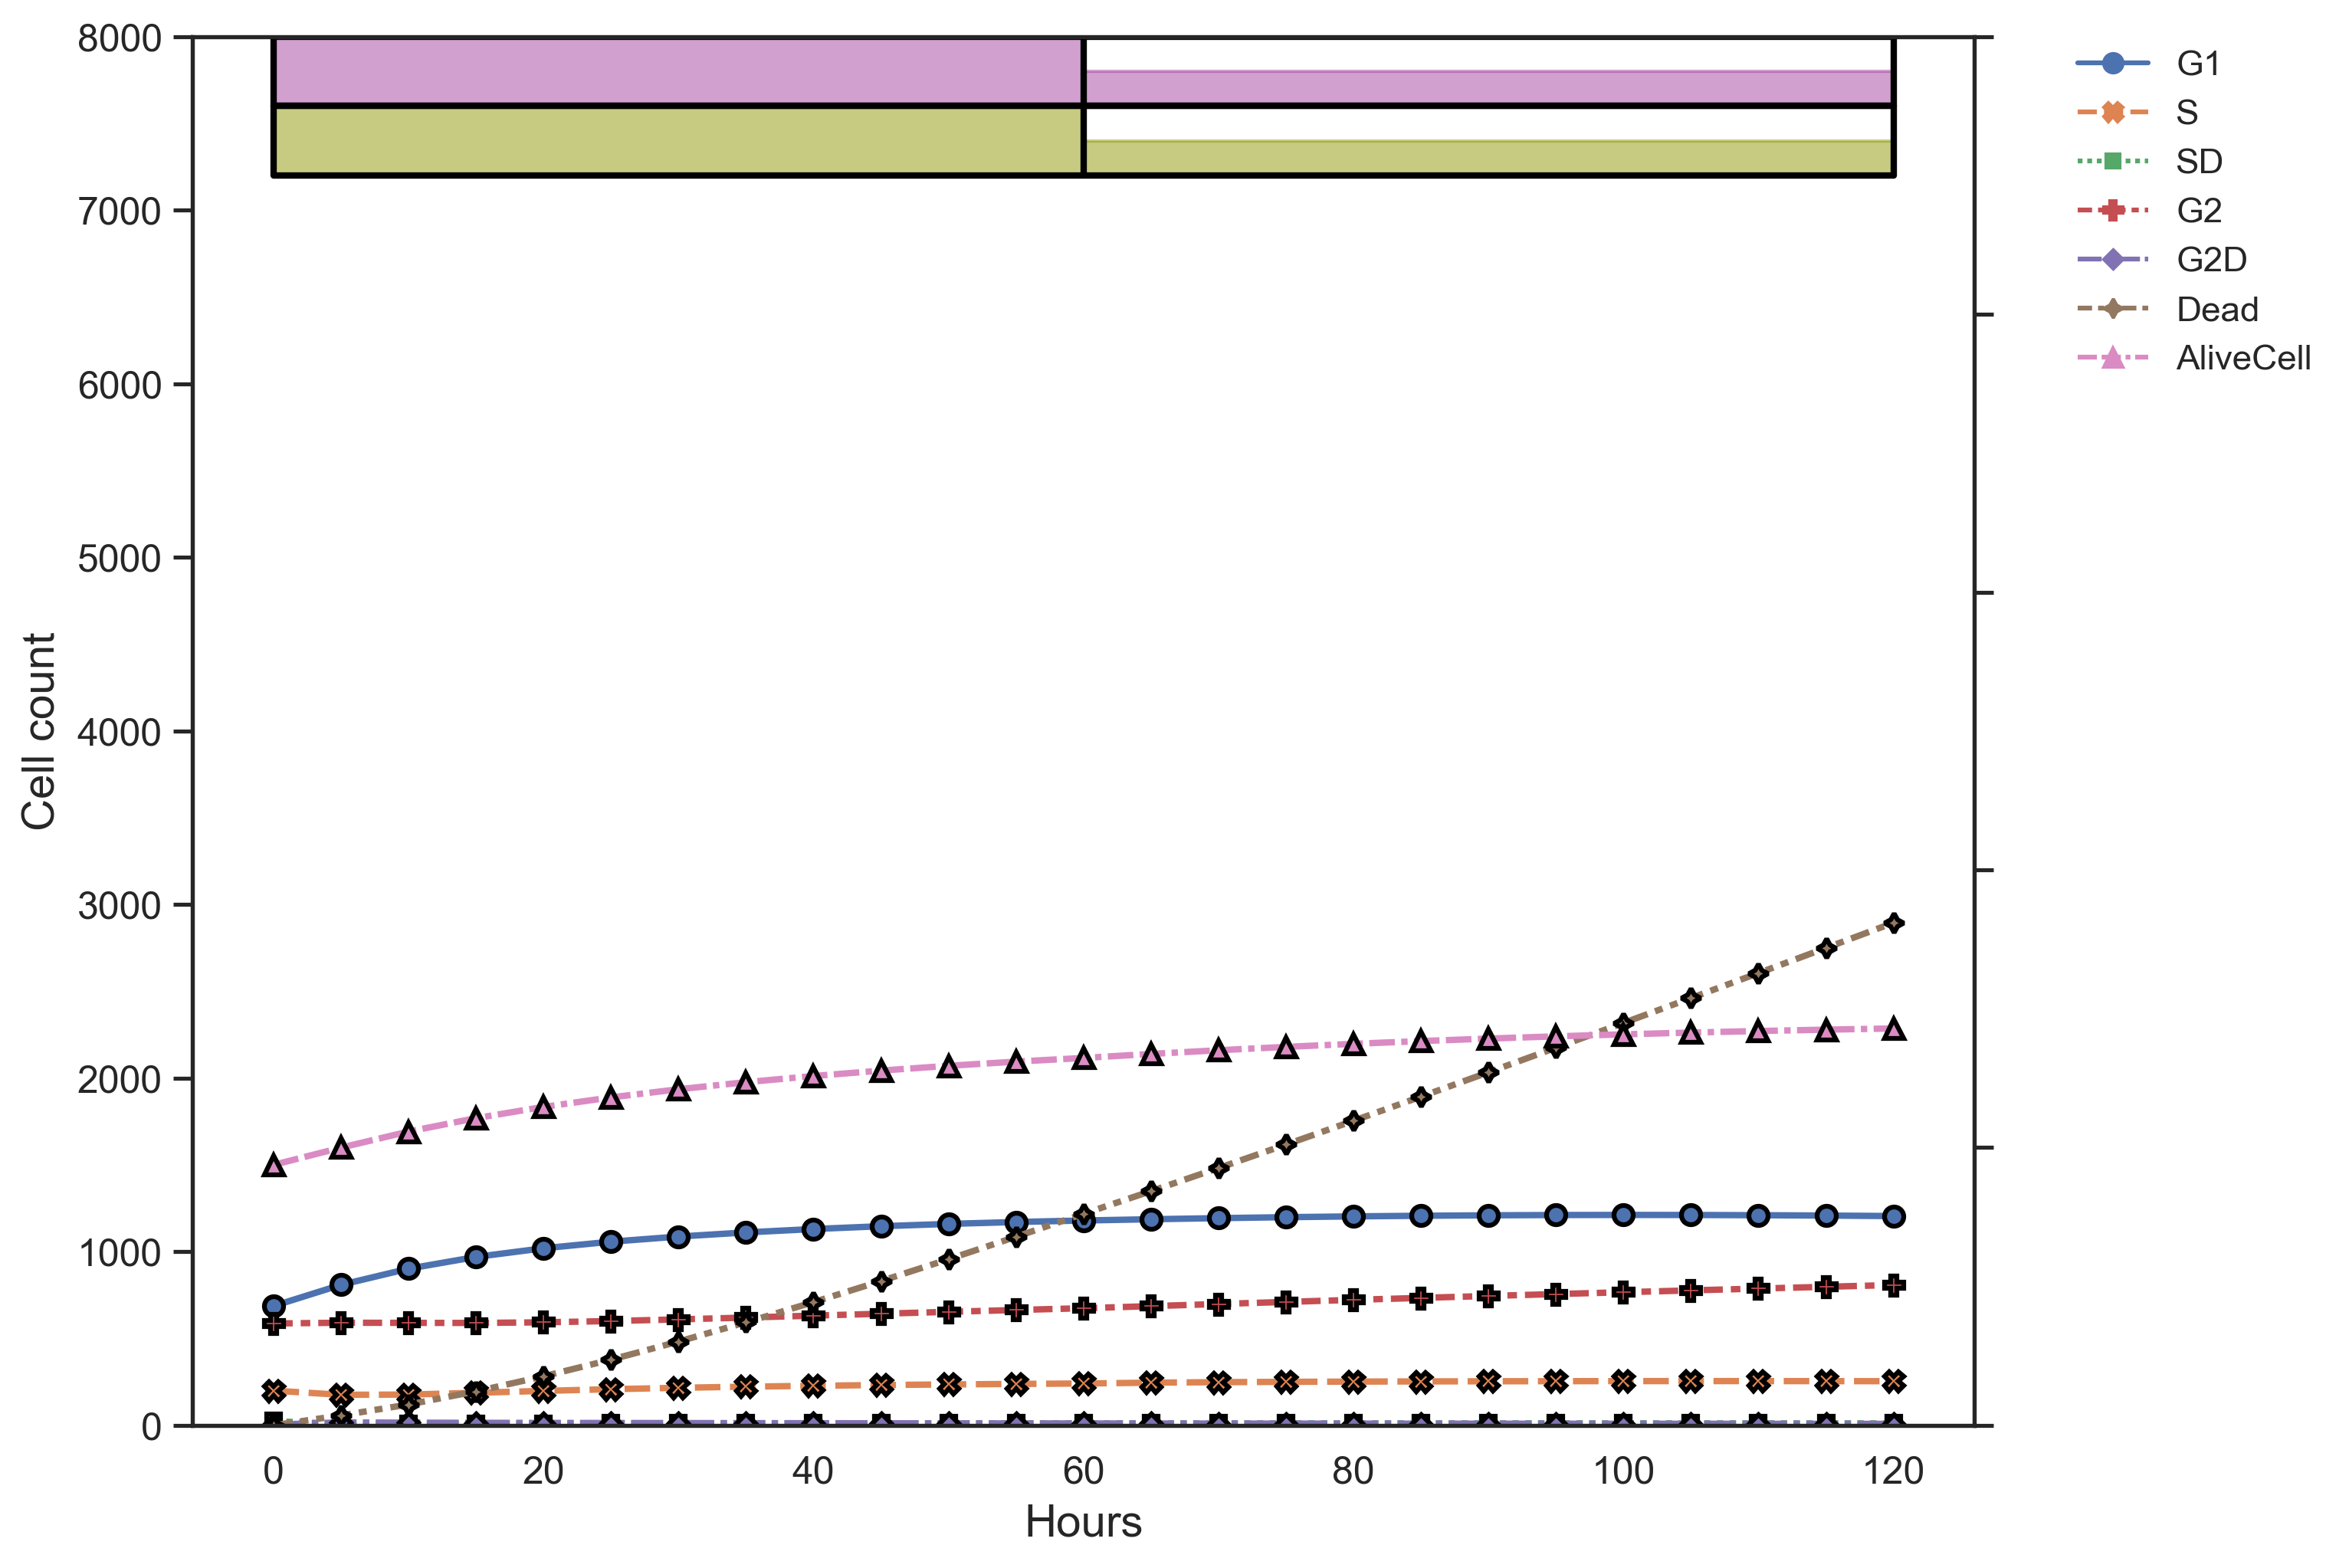

Last AliveCell datapoint: 2285.950872893516


In [5]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,20,1,1], [20,40,1,1], [40,60,1,1], [60,80,0.5,0.5], [80,100,0.5,0.5], [100,121,0.5,0.5]])
myModel.Trim(dt=5.)

data_df_wide = myModel.resultsDf
data_df_wide['AliveCell'] = data_df_wide['TumourSize'] - data_df_wide['Dead']

# Add 'alivecell' to the list of variables to plot
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'AliveCell']
#variables_to_plot = ['AliveCell']
data_df_long = pd.melt(
    data_df_wide, 
    id_vars=['Time'], 
    value_vars=myModel.stateVars + ["AliveCell"], 
    var_name='Variable', 
    value_name='Value'
)

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 8000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Hours", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug2_Concentration", "Drug1_Concentration"],
    drug_bar_position=0.9, 
    max_dose=[1, 1],
    drugBarColours=sns.xkcd_palette(['baby poop green', 'ugly purple']),
    ax=ax
)

plt.show()

# Print the last data point of TumourSize
AliveCell_72 = data_df_wide['AliveCell'].iloc[-1]
print("Last AliveCell datapoint:", AliveCell_72)

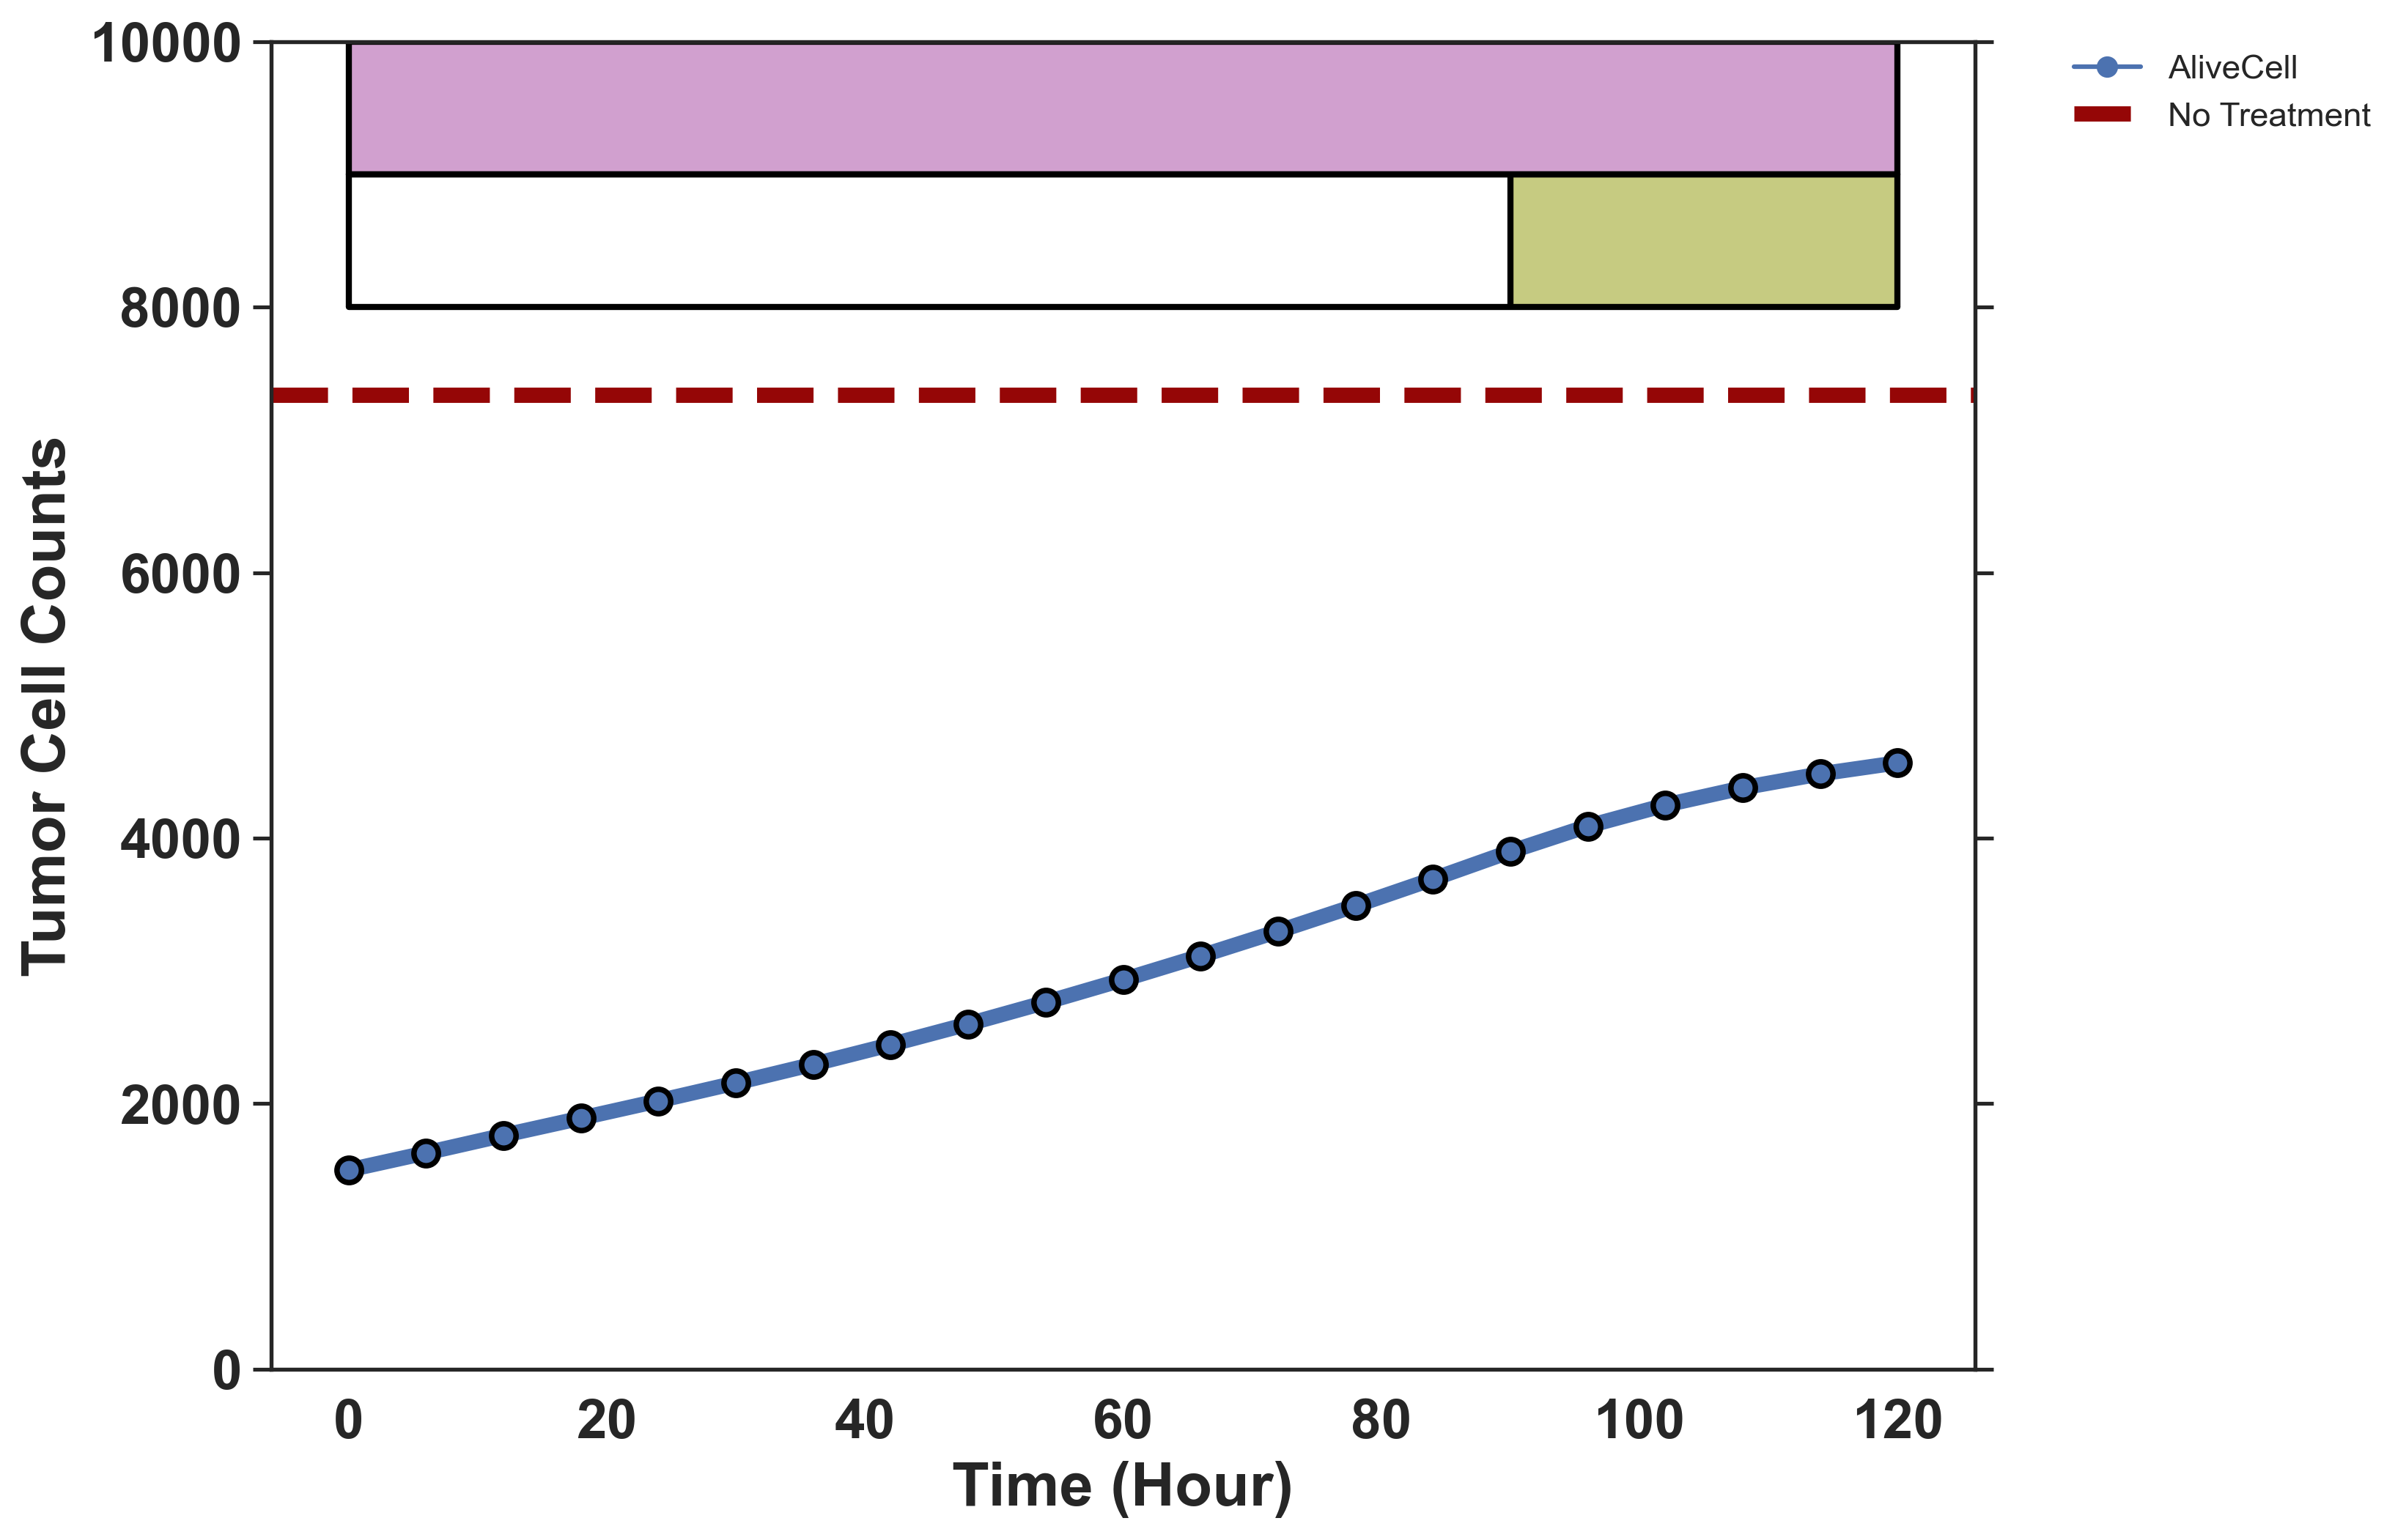

Last AliveCell datapoint: 4567.324639002092


In [5]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
#myModel.Simulate(treatmentScheduleList=[[0,20,1,1], [20,40,1,1], [40,60,1,1], [60,80,1,0], [80,100,1,0], [100,121,1,0]])
#myModel.Simulate(treatmentScheduleList=[[0,60,1,0], [60,121,0,1]])
myModel.Simulate(treatmentScheduleList=[[0,30,1,0], [30,60,1,0], [60,90,1,0], [90,121,1,1]])
#myModel.Simulate(treatmentScheduleList=[[0,40,1,0], [40,80,0,1], [80,121,0,0]])
#myModel.Simulate(treatmentScheduleList=[[0,40,1,0], [40,80,0,1], [80,121,0,0]])
myModel.Trim(dt=6.)

data_df_wide = myModel.resultsDf
# Calculate alivecell as TumourSize - Dead
data_df_wide['AliveCell'] = data_df_wide['TumourSize'] - data_df_wide['Dead']

# Add 'alivecell' to the list of variables to plot
#variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'AliveCell']
variables_to_plot = ['AliveCell']
data_df_long = pd.melt(
    data_df_wide, 
    id_vars=['Time'], 
    value_vars=myModel.stateVars + ["AliveCell"], 
    var_name='Variable', 
    value_name='Value'
)

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=5, markersize=8, markeredgewidth=1.8,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

ax.axhline(y=7336, color='#950606', linestyle='--', linewidth=5, label='No Treatment')

# Adjust the y-axis limit
ax.set_ylim([0, 10000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time (Hour)", fontsize=20, fontweight="bold")
ax.set_ylabel("Tumor Cell Counts", fontsize=20, fontweight="bold")

for tick in ax.get_xticklabels():
    tick.set_fontweight("bold")
for tick in ax.get_yticklabels():
    tick.set_fontweight("bold")

ax.tick_params(axis='both', which='major', labelsize=18)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug2_Concentration", "Drug1_Concentration"],
    drug_bar_position=0.8, 
    max_dose=[1, 1],
    drugBarColours=sns.xkcd_palette(['baby poop green', 'ugly purple']),
    ax=ax
)

plt.show()

# Print the last data point of TumourSize
AliveCell_72 = data_df_wide['AliveCell'].iloc[-1]
print("Last AliveCell datapoint:", AliveCell_72)

Heatmaps

In [6]:
data_df_wide['AliveCell']

0     1500.000000
1     1628.677132
2     1761.194242
3     1890.417517
4     2020.874187
5     2155.686462
6     2296.638831
7     2444.583590
8     2599.942707
9     2762.911451
10    2933.530467
11    3111.838789
12    3297.710065
13    3490.961557
14    3691.315349
15    3898.354472
16    4090.163138
17    4248.755155
18    4378.590098
19    4483.605018
20    4567.324639
Name: AliveCell, dtype: float64

In [7]:
import itertools
# Initialize a list to store the results for each combination
results = []

# Generate all possible combinations of [0.5, 1] for d2 of length 6
for d2 in itertools.product([0, 1], repeat=6):
    if sum(d2) == 3:  # Only keep combinations where the sum is 3
        # Set the treatment schedule based on the current combination
        treatment_schedule = [[0, 20, 1, d2[0]], [20, 40, 1, d2[1]], [40, 60, 1, d2[2]], 
                              [60, 80, 1, d2[3]], [80, 100, 1, d2[4]], [100, 121, 1, d2[5]]]
        
        # Simulate with the current treatment schedule
        myModel.Simulate(treatmentScheduleList=treatment_schedule)
        
        # Trim the results
        myModel.Trim(dt=5.)
        
        # Get the results data frame and calculate AliveCell
        data_df_wide = myModel.resultsDf
        data_df_wide['AliveCell'] = data_df_wide['TumourSize'] - data_df_wide['Dead']
        
        # Extract the last AliveCell data point
        alive_cell_120 = data_df_wide['AliveCell'].iloc[-1]
        
        # Store the combination and the AliveCell result
        results.append({'d2_combination': d2, 'Last_AliveCell': alive_cell_120})

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print("Results for all d2 combinations where the sum is 3:")
print(results_df)


Results for all d2 combinations where the sum is 3:
        d2_combination  Last_AliveCell
0   (0, 0, 0, 1, 1, 1)     3750.606941
1   (0, 0, 1, 0, 1, 1)     3476.964364
2   (0, 0, 1, 1, 0, 1)     3333.173646
3   (0, 0, 1, 1, 1, 0)     3231.962279
4   (0, 1, 0, 0, 1, 1)     3257.494452
5   (0, 1, 0, 1, 0, 1)     3106.264456
6   (0, 1, 0, 1, 1, 0)     3004.362742
7   (0, 1, 1, 0, 0, 1)     2997.918396
8   (0, 1, 1, 0, 1, 0)     2890.185062
9   (0, 1, 1, 1, 0, 0)     2811.392898
10  (1, 0, 0, 0, 1, 1)     3089.404349
11  (1, 0, 0, 1, 0, 1)     2931.538335
12  (1, 0, 0, 1, 1, 0)     2828.758900
13  (1, 0, 1, 0, 0, 1)     2815.852149
14  (1, 0, 1, 0, 1, 0)     2707.419780
15  (1, 0, 1, 1, 0, 0)     2627.671034
16  (1, 1, 0, 0, 0, 1)     2737.679786
17  (1, 1, 0, 0, 1, 0)     2623.748772
18  (1, 1, 0, 1, 0, 0)     2538.839739
19  (1, 1, 1, 0, 0, 0)     2483.130128


In [8]:
lowest_alive_cell_combination = results_df.loc[results_df['Last_AliveCell'].idxmin()]

lowest_alive_cell_combination

d2_combination    (1, 1, 1, 0, 0, 0)
Last_AliveCell           2483.130128
Name: 19, dtype: object

In [9]:
# Initialize storage for results
results = {}

# Define parameter ranges
d1_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]  # d1 values from 1 to 0.1
d2_options = [
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]

# Loop through each combination of d1 and d2
for d1 in d1_values:
    for d2 in d2_options:
        # Initialize model and set parameters
        myModel = create_model("CellCycleModel")
        myModel.SetParams(
            G10=1500 * 0.458, S0=1500 * 0.133, SD0=1500 * 0.0157,
            G20=1500 * 0.391, G2D0=1500 * 0.0023, Dead0=0, A10=0
        )
        
        # Define treatment schedule and simulate
        myModel.Simulate(treatmentScheduleList=[
            [0, 30, d1, d2[0]],
            [30, 60, d1, d2[1]],
            [60, 90, d1, d2[2]],
            [90, 121, d1, d2[3]]
        ])
        myModel.Trim(dt=5.0)
        
        # Retrieve results and calculate AliveCell
        data_df_wide = myModel.resultsDf
        data_df_wide['AliveCell'] = data_df_wide['TumourSize'] - data_df_wide['Dead']
        
        # Store the final AliveCell value at time step 120
        AliveCell_120 = data_df_wide['AliveCell'].iloc[-1]
        
        # Save the result in the dictionary
        results[(d1, tuple(d2))] = AliveCell_120

# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['AliveCell_120']).reset_index()

# Split the tuple in the 'index' column into 'd1' and 'd2' and drop the original 'index' column
results_df[['d1', 'd2']] = pd.DataFrame(results_df['index'].tolist(), index=results_df.index)
results_df = results_df.drop(columns=['index'])

# Display the final DataFrame
results_df


,AliveCell_120,d1,d2
0,3076.731368,1.0,"(1, 0, 0, 0)"
1,3418.715231,1.0,"(0, 1, 0, 0)"
2,3910.168780,1.0,"(0, 0, 1, 0)"
3,4567.324639,1.0,"(0, 0, 0, 1)"
4,3102.479401,0.9,"(1, 0, 0, 0)"
5,3445.031022,0.9,"(0, 1, 0, 0)"
6,3937.313081,0.9,"(0, 0, 1, 0)"
7,4595.532589,0.9,"(0, 0, 0, 1)"
8,3131.726854,0.8,"(1, 0, 0, 0)"
9,3474.934571,0.8,"(0, 1, 0, 0)"


<AxesSubplot:xlabel='d2', ylabel='d1'>

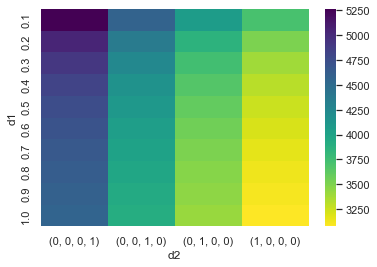

In [10]:
df_mat = results_df.pivot(index='d1', columns='d2', values='AliveCell_120')
# df_mat = df_mat.reset_index()
sns.heatmap(df_mat, cmap='viridis_r')

In [92]:
import numpy as np
from scipy.stats import linregress

# Cell count data
cell_count = np.array([1500.0, 1599.430789, 1691.999248, 1769.323880, 1834.027118,
                       1888.784294, 1935.729017, 1979.487896, 2023.679714, 2069.310001,
                       2116.985388, 2167.045973, 2219.678550, 2275.026151, 2333.162235,
                       2394.149769, 2458.039796, 2524.873619, 2594.671019, 2667.484726,
                       2743.316521, 2822.171316, 2904.042038, 2988.907364, 3076.731368])

#cell_count = np.array([1500.0, 1605.978898, 1717.622599, 1825.913565, 1933.576643,
#                       2042.981182, 2155.686462, 2272.677504, 2394.459564, 2521.320360,
#                       2653.414649, 2790.818898, 2933.530467, 3081.591641, 3234.922199,
#                       3393.428292, 3556.973513, 3725.372939, 3898.354472, 4075.693682,
#                       4257.003198, 4441.864057, 4629.792263, 4820.234475, 5012.568573])

# Define time points (in hours)
time_points = np.linspace(0, 120, len(cell_count))

# Fit linear regression
slope, intercept, r_value, _, _ = linregress(time_points, cell_count)

# The slope represents the linear growth rate per hour
linear_growth_rate_per_hour = slope
linear_growth_rate_per_hour


12.070640914461542

In [8]:
# Define drug concentration lists
drug_1_concentrations = [0, 0.03, 0.1, 0.3, 0.5, 0.7, 1]
drug_2_concentrations = [0, 0.03, 0.1, 0.3, 0.5, 0.7, 1]

# Initialize model and set parameters
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, 
                  G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0)

# Prepare a DataFrame to store the results for each concentration
results_summary = []

# Iterate over each concentration of drug_1 and drug_2
for d1 in drug_1_concentrations:
    for d2 in drug_2_concentrations:
        # Update treatment schedule with current concentrations of drug 1 and drug 2
        treatment_schedule = [[0,120, d1, d2]]
        myModel.Simulate(treatmentScheduleList=treatment_schedule)
        myModel.Trim(dt=5.)
        
        # Access the simulation results
        data_df_wide = myModel.resultsDf
        
        # Calculate alive cells
        data_df_wide['AliveCell'] = data_df_wide['TumourSize'] - data_df_wide['Dead']
        
        # Get the last data point for AliveCell
        AliveCell_120 = data_df_wide['AliveCell'].iloc[-1]
        #print(f"Drug 1 concentration {d1}, Drug 2 concentration {d2}, Last AliveCell datapoint:", AliveCell_72)
        
        # Append the result to the summary list
        results_summary.append({
            'Drug 1 Concentration': d1,
            'Drug 2 Concentration': d2,
            'Last AliveCell': AliveCell_120
        })

# Convert results summary to a DataFrame for further analysis or export
results_df = pd.DataFrame(results_summary)

results_df.to_excel("alive_cell_results.xlsx", index=False)
print("Results saved to alive_cell_results.xlsx")

Results saved to alive_cell_results.xlsx
